# Problem: Challenger Space Shuttle Disaster 

## Problem Description
>On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. 

So, the major issue in Challenger Space Shuttle Problem is to predict whether the disaster would happen or not, or more specifically, the probability of happening, given a certain temperature $t$.

We are going to solve this problem by using Bayesian method and sampling technique. Unlike the solution using pymc module in *Probabilistic Programming and Bayesian Methods for Hackers*, I simply use sample method. Besides, I try to apply a different method of modeling, and then illustrate the validity of my modeling by doing cross validation.

The Python verion I use is Python 3.6. And here are the most basic packages it may concerned in the following codes.

*** key words: logistic function, Bayesian posterior, priors, MCMC, time complexity, logistic regression classifier, cross validation***

In [119]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.stats import distributions
%matplotlib inline

## Data Description
Right now the commision has the following 23 data on the Challenger Space Shuttle. As shown in **data/challenger_data.csv**. The first column is the temperature ($t$), and the second column is the failure of the O-ring ($h$), $h$ = 0 stands for the damage incident and $h$ = 1 stands for not being damaged.

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


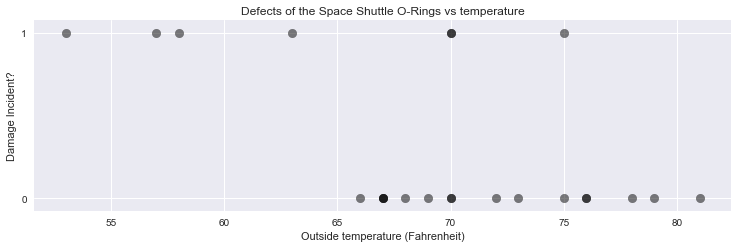

In [120]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k", alpha=0.5)
t = challenger_data[:, 0]
h = challenger_data[:, 1]

plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")
plt.show()

## Problem Analysis and Mathematical Preparation

It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The happening of damage is a discrete dummy variable, nevertheless,  probability of damage is a continuous one, as a result, we are able to depict the probability of the damage incident by the introdution of some certain function.

### Introduction of Logitic Function

As the analysis above, we need a function of temperature to depict the probability of happening, which is bounded between 0 and 1, and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

,where  $\alpha$ and $\beta$ are two parameters in the logistic function. Some plots are below, with differing $\alpha$ and $\beta$.

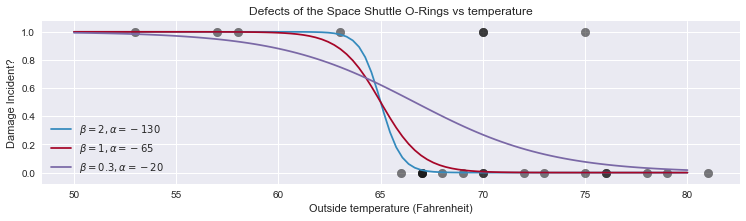

In [121]:
figsize(12.5, 3)
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(50, 80, 100)

#plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
#plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
#plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.plot(x, logistic(x, 2, -130), label=r"$\beta = 2, \alpha = -130$",color="#348ABD")
plt.plot(x, logistic(x, 1, -65), label=r"$\beta = 1, \alpha = -65$",color="#A60628")
plt.plot(x, logistic(x, 0.3,-20), label=r"$\beta = 0.3, \alpha = -20$", color="#7A68A6")
#plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");
plt.legend(loc="lower left")
plt.show()

### Features of Logistic Function

From the plots above, it can be found that $\beta$ determined the "changing rate" and "changing direction". When $\beta$ is positive, the function changes from 1 to 0 with the increase of temperature, and the larger the absolute value of $\beta$ is, the quicker it change from 1 to 0(or from 0 to 1). For parameter $\alpha$, it can be regarded as a "bias term" of the function. From a mathematical perspective, when $\beta t +\alpha = 0, p(t)=0.5$, so $-\alpha/\beta$ determines the "center" of the variation.

It seems that $\beta$ and $-\alpha/\beta$ are two important parameters in this modeling, $\beta$ can be regarded as a ***scale*** term and $-\alpha/\beta$,a ***location*** term. Given that, to be simple, denote $-\alpha/\beta$ as $k$. Thus, $\beta t+\alpha$ is transformed to $\beta(t-k)$, and the logistic function is transformed as:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta(t-k) } } $$

## Modeling

After introducing the logistic function and its transformed form. Right now we are trying to build the model for the Challenge Space Shuttle problem. The basic idea is to use Bayesian posterior to estimate the happening probability of damage incident. And the major issue now is to determine the parameters, $\beta$ and $\k$, by maximizing a posterior(MAP). Befor doing that, it will be clear to list the probabilities, priors, likelihoods, etc.

### Probabilities may concerned
Denote the probability $p(t)$ as $y$. 
We have our probabilities $y$s, but how do we connect them to our observed data $h$? A *Bernoulli* random variable with parameter $y$, denoted $\text{Ber}(y)$, is a random variable that takes value 1 with probability $y$, and 0 else. Thus, the damage incident $h_i$ can be depict as a Bernoulli distribution with probability = $y_i$

$$ \text{Defect Incident, $h_i$} \sim \text{Ber}(\;y_i\;) = y_i^{h_i}(i-y_i)^{1-h_i}, \;\; i=1..N, h_i = 0,1$$

Then denote $H$ as a set of $h_i$s, and $Y$ as a set of $y_i$s.

- Distribution of probability: $P(y_i|t_i,\beta,k) = \frac{1}{ 1 + e^{ \;\beta(t_i-k) } } $
- Distribution of happening: $P(h_i|y_i) = y_i^{h_i}(i-y_i)^{1-h_i},\; h_i = 0,1$
- Likelihood of happening: $P(H|Y)=\prod\limits_{i=1}^{n}{{{y}_{i}}^{hi}(1-}{{y}_{i}}{{)}^{1-hi}}$

For distribution of happening, if we use $\alpha$,$\beta$ and $t_i$ to discribe it, the distribution can be wiritten as:
$$P(h|t,\beta ,k)=1+{{e}^{\beta (t-k)}}{{}^{-h}}{{\left( \frac{{{e}^{\beta (t-k)}}}{1+{{e}^{\beta (t-k)}}} \right)}^{1-h}}=\frac{{{e}^{\beta (t-k)(1-h)}}}{1+{{e}^{\beta (t-k)}}}$$
Then the likelihood is:
$$P(H|T,\beta ,k)=\prod\limits_{{{t}_{i}}\in T}{\frac{{{e}^{\beta (t-k)(1-hi)}}}{1+{{e}^{\beta ({{t}_{i}}-k)}}}},h_i=0,1$$

### Baysian Posterior

The Bayes' Rule gives us an awesome way to find the distribution according to the observations - posterior distribution, and the rule can be simply described as:

$$Posterior\propto Likelihood\times Prior$$

Since the unknowns in our problem are a little bit complex, before caculating the posteriors, whether joint or conditional, let's first find the conditional independence among the variables(or simply, call them features). For the two parameters, $k$ and $\beta$, when given the observations, $H$ and $T$, they are conditional independent! Thus the posteriors are the followings:

$$P(\beta ,k|H,T)\propto jointprior(\beta ,k)\times likelihood$$

$$P(\beta |k,H,T)\propto prior(\beta )\times likelihood$$

$$P(k|\beta ,H,T)\propto prior(k)\times likelihood$$

And next, the subproblem is to design the priors.

## Design the Priors - a heuristic approach

Given that we have only 23 samples(ie. observations), which is not so large that could make the priors to lose their powers. As a result, the proposal of priors will be very essential in this problem, and apparently, a non-informative prior is not appropriate in the solution. And the following parts(as a major part) will discuss the influence of different priors and choose the better one as our final prior. To be notice, I will dedicate a large portion of this  report on choosing suitable heuristic(also known as informative) priors.

### Heursitic priors 1:

Recall that we've ploted the logistic function in *Problem Analysis and Preparations*, and this gives a lot of ideas to me, in order to fit the function better, $\beta$ should always positive. $k$,also positive, the location parameter, is roughly located between 60 and 70. Why? Visually speaking from the plot above, it seems that when temperature are higher than 65, the damage incident seems unlikely to happen.

Since $\beta$ should be always positive, the fist idea came into my mind, intuitively, is gamma distribution. What's more, $\beta$ can not be too large (if large, the change is sharp). An average of one may be an appropriate value for $\beta$ in the solution. And for k, normal distribution with mean = 65 may be suitable.

In order to select parameters of our priors, we plot gamma distributions and normal distributions.

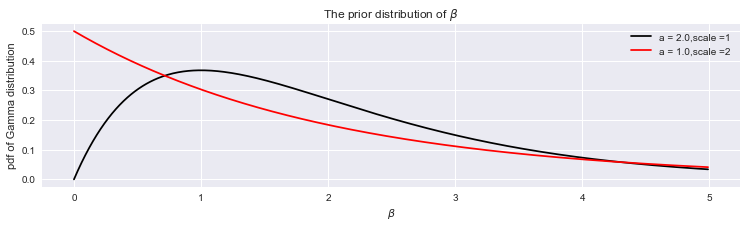

In [122]:
beta = np.arange(0,5,0.01)
Y1= sp.stats.gamma.pdf(beta,a = 2.0,scale =1)
Y2= sp.stats.gamma.pdf(beta,a = 1.0,scale =2)
plt.plot(beta,Y1,color="k",label = 'a = 2.0,scale =1')
plt.plot(beta,Y2,color="red",label = 'a = 1.0,scale =2')

plt.xlabel(r'$\beta $')
plt.ylabel('pdf of Gamma distribution')
plt.title(r"The prior distribution of $\beta $")
plt.legend()
plt.show()

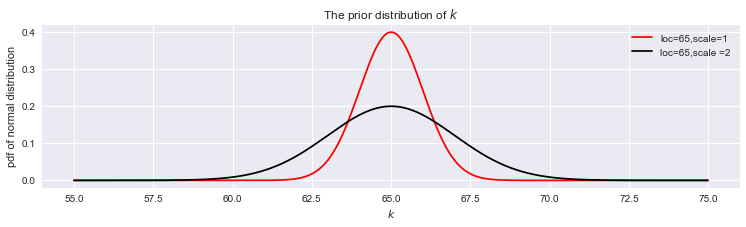

In [123]:
Y1 = sp.stats.norm(loc=65,scale=1)
Y2 = sp.stats.norm(loc=65,scale =2)
k = np.arange(55,75,0.01)
plt.plot(k,Y1.pdf(k),label="loc=65,scale=1",color="red")
plt.plot(k,Y2.pdf(k),label="loc=65,scale =2",color="k")
plt.xlabel('$k$')
plt.ylabel('pdf of normal distribution')
plt.title(r"The prior distribution of $k$")
plt.legend()
plt.show()

### Choose the prior parameters

Well, there is no systemic method to choose priors, after all even if the prior is not good, it doesn't matter, most of the condition, it is just a intuition and common sense. Here, I would like to choose $\beta$ ~ Gamma(a = 2,scale = 1), and $k$ ~ N(loc = 65,scale = 2). Therefor we can compute the likelihood, conditional posteriors, and joint posterior by applying Bayes Rule.

In [124]:
def likelihood(h,t,k,beta):
    ans = 1
    for i in range(len(t)):
        ans = ans * np.exp((1-h[i])*beta*(t[i]-k))/(1.0 + np.exp(beta * (t[i]-k)))
    return ans

def k_condition(k,beta,h,t):
    prior  = sp.stats.norm.pdf(k,loc = 65,scale = 2)
    posterior = prior * likelihood(h,t,k,beta)
    return posterior

def beta_condition(beta,k,h,t):
    prior = sp.stats.gamma.pdf(beta,a=2.0,scale=1)
    posterior = prior * likelihood(h,t,k,beta)
    return posterior

def joint_posterior(beta,k,h,t):
    joint_prior = sp.stats.norm.pdf(k,loc = 65,scale = 2) * sp.stats.gamma.pdf(beta,a=2.0,scale=1)
    joint_posterior = joint_prior * likelihood(h,t,k,beta)
    return joint_posterior

Also we can visualize the joint posterior.

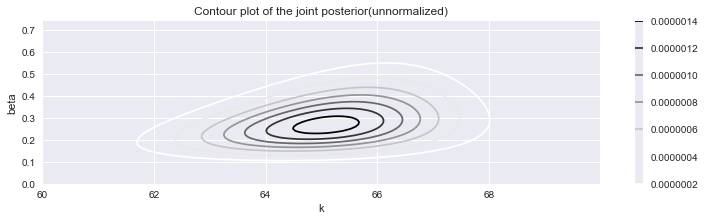

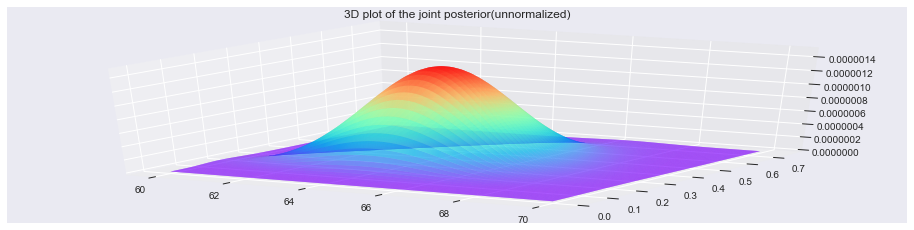

In [61]:
n = len(challenger_data)
t = challenger_data[:,0]
h = challenger_data[:,1]
k = np.arange(60,70,0.01)
beta = np.arange(0,0.75,0.01)
k, beta = np.meshgrid(k,beta)
z = joint_posterior(beta,k,h,t)
plt.figure()
CS = plt.contour(k,beta,z)
plt.xlabel('k')
plt.ylabel('beta')
plt.title('Contour plot of the joint posterior(unnormalized)')
plt.colorbar()
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(k,beta,z, rstride=1, cstride=1, cmap='rainbow')
plt.title('3D plot of the joint posterior(unnormalized)')
plt.show()


## Sampling from Posteriors

### Gibbs Sampler

From *modeling*, we find that the posteriors are not so easy for us to sample. Given that there are two variables we want to sample, $\beta$ and $k$ and on the other hand, I've computed the conditional distribution. The most straight idea is to use Gibbs Sampler. The pesudo-code is given by:
> Initialize $k_0$
> 
Repeat
>> 
   sample $\beta_i$ ~ beta_condition($k_i-1$)
>> 
   sampel $k_i$ ~ k_condition($\beta_i$)

### Metropolis–Hastings(or simply Metropolis)

Even though Gibbs gives a clear way to sample, it is hard to sample variable from the conditional posterior, so Metropolis-hastinga are used in each iteration of sampling from conditional distributions.(The pesudo-code is the same as lecture notes, and here I don't want to repeat it again.)

### Implement

Setting maximum number of iteration = 1000 in Gibbs sampler, and in MH sampler, each iterates 500 times. As a result the time complexity is O(1000*500*23*2). The reality is, it indeed spend much time in sampling.

In [125]:
def draw_beta(beta_init,k,h,t):
    # using MH, draw beta from target distribution = beta_condition(beta,k,h,t)
    #init
    beta_list =[]
    b0 = beta_init
    beta_list.append(b0)
    # repeat
    for i in range(1,500):
        u = np.random.uniform(0,1)
        b_star = np.random.normal(loc = beta_list[i-1],scale = 0.05)
        while(b_star<=0):
            b_star = np.random.normal(loc = beta_list[i-1],scale = 0.05)
        #print(b_star,beta_list[i-1])
        #print(beta_condition(b_star,k = k,h = h,t =t))
        acc = min(1, 1.0*beta_condition(b_star,k = k,h = h,t =t)/beta_condition(beta_list[i-1],k=k,h=h,t=t))
        #print(acc)
        if u < acc:
            beta_list.append(b_star)
        else:
            beta_list.append(beta_list[i-1])
    #print('rest:::',beta_list[-1])       
    return beta_list[-1]
    
    
def draw_k(k_init,beta,h,t):
    #MH, draw k from target = k_condition(k,beta,h,t)
    #init
    k_list = []
    k0 = k_init
    k_list.append(k0)
    #repeat
    for i in range(1,500):
        u = np.random.uniform(0,1)
        k_star = np.random.normal(loc = k_list[i-1],scale = 1)
        while (k_star<=0):
            k_star = np.random.normal(loc = k_list[i-1],scale = 1)
        #print(k_star,k_list[i-1])
        #print(k_condition(k_star,beta=beta,h=h,t=t))
        acc = min(1,1.0*k_condition(k_star,beta=beta,h=h,t=t)/k_condition(k_list[i-1],beta=beta,h=h,t=h))
        if u < acc:
            k_list.append(k_star)
        else:
            k_list.append(k_list[i-1])
    #print("res:::",k_list[-1])
    return k_list[-1]
    
def gibbs(h,t,N_iter):
    #init
    k_trace =[]
    beta_trace =[]
    k0 = np.random.uniform(low =30,high= 80)
    k_trace.append(k0)
    b0 = np.random.uniform(0,3)
    beta_trace.append(b0)
    
    for i in range(1,N_iter):
        if (i% 300 == 0):
            print('We have iterated',i,'times.')
        #sample beta[i] from beta_condition
        b = draw_beta(beta_trace[i-1],k_trace[i-1],h,t)
        beta_trace.append(b)
        #sample k[i] from k_condition
        a = draw_k(k_trace[i-1],beta_trace[i],h,t)
        k_trace.append(a)
    
    return beta_trace,k_trace

In [126]:
import warnings
warnings.filterwarnings("ignore")
beta, k = gibbs(h=h,t=t,N_iter = 1000)

We have iterated 300 times.
We have iterated 600 times.
We have iterated 900 times.


### Convergence Test

Set burn-in period = 100, then test the convergence of our sampler, to see whether it converges after 1000 iteration. We first observe the autocorrelation, then do Geweke test.

In [127]:
def autocorr(x):
    result= np.correlate(x, x, mode='full')
    result = result/result[result.size/2.0]
    return result[result.size/2.0]

64.2803878453
457.025950852


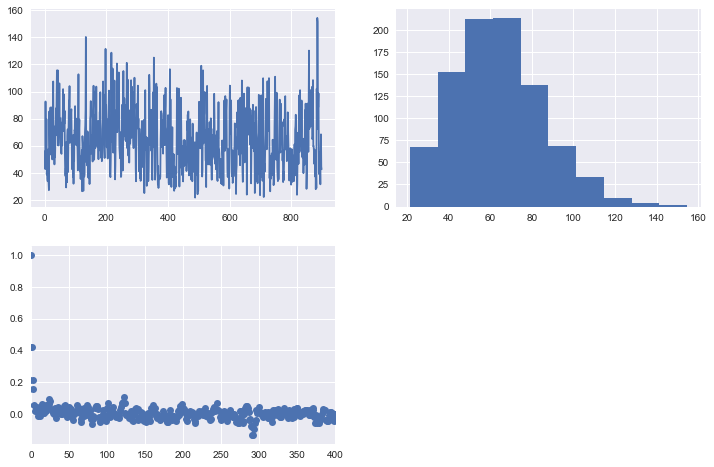

In [128]:
burnin = 100
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(k[burnin:])
plt.subplot(2,2,2) 
fig=plt.hist(k[burnin:])
plt.subplot(2,2,3)
plt.acorr(k[burnin:]-np.mean(k[burnin:]),  normed=True, usevlines=False, maxlags=400, label=u'Shuffled')

plt.xlim( (0,400))
print(np.mean(k[burnin:]))
print(np.var(k[burnin:]))

0.109618647969
0.0131090144313


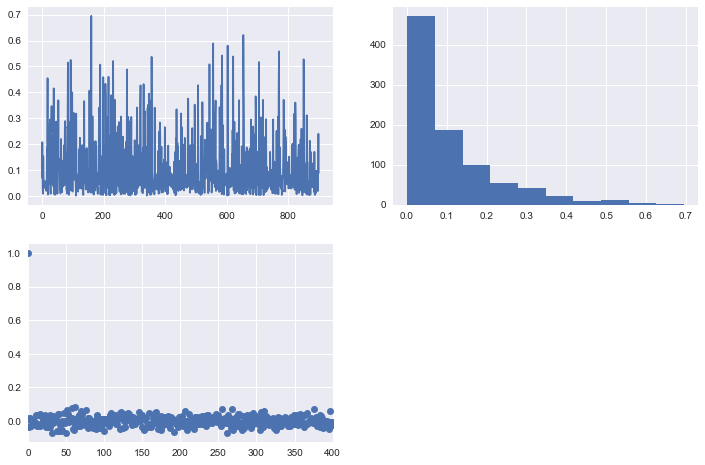

In [129]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(beta[burnin:])
plt.subplot(2,2,2) 
fig=plt.hist(beta[burnin:])
plt.subplot(2,2,3)
plt.acorr(beta[burnin:]-np.mean(beta[burnin:]),  normed=True, usevlines=False, maxlags=400, label=u'Shuffled')

plt.xlim( (0,400))
print(np.mean(beta[burnin:]))
print(np.var(beta[burnin:]))

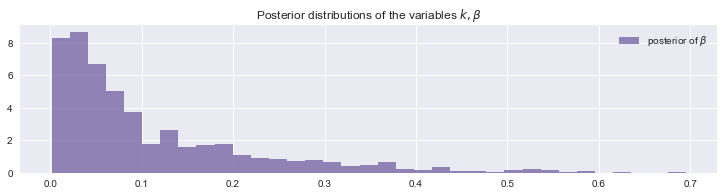

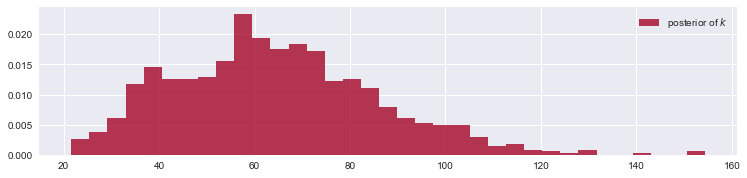

In [130]:
figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $k, \beta$")
plt.hist(beta[burnin:], histtype='stepfilled', bins=35, alpha=0.8,label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()
plt.show()

plt.subplot(212)
plt.hist(k[burnin:], histtype='stepfilled', bins=35, alpha=0.8,label=r"posterior of $k$", color="#A60628", normed=True)
plt.legend()
plt.show()

From the autocorrelation, the chain roughly converges and then do Geweke test - a formal approach.

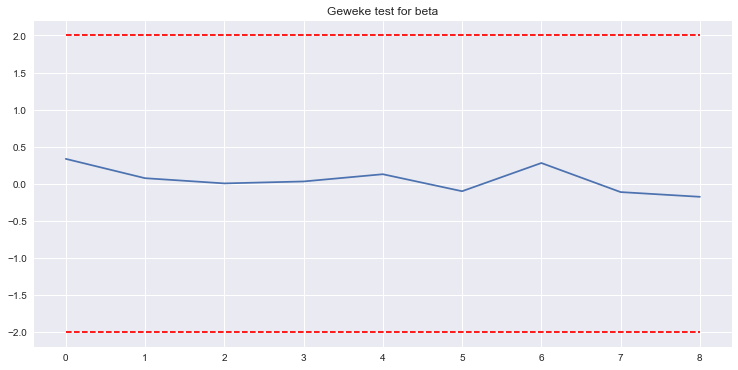

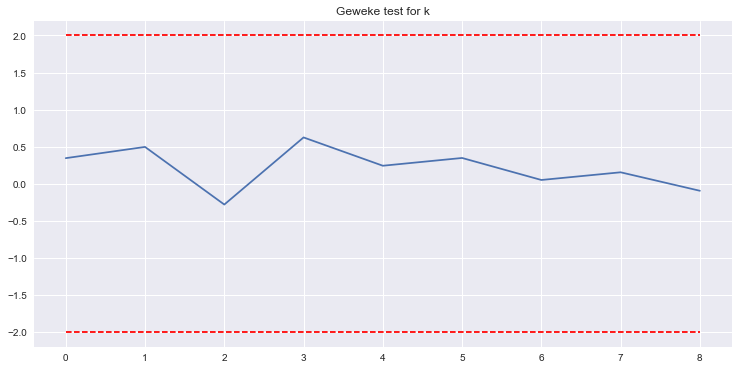

In [131]:
#geweke test
# beta
z_beta = []
z_k = []
halfLen = 500
for i in range(9):
    ba = beta[burnin+50*i:burnin+50*(i+1)]
    bb = beta[halfLen+50*i:halfLen+50*(i+1)]
    z_beta.append((np.mean(ba)-np.mean(bb))/np.sqrt(np.var(ba)+np.var(bb)))
#print(z_beta)
plt.plot(range(9),z_beta)
plt.plot([2]*9,'r--')
plt.plot([-2]*9,'r--')
plt.title('Geweke test for beta')
plt.show()
# k
for i in range(9):
    ka = k[burnin+50*i:burnin+50*(i+1)]
    kb = k[halfLen+50*i:halfLen+50*(i+1)]
    z_k.append((np.mean(ka)-np.mean(kb))/np.sqrt(np.var(ka)+np.var(kb)))
#print(z_k)
plt.plot(range(9),z_k)
plt.plot([2]*9,'r--')
plt.plot([-2]*9,'r--')
plt.title('Geweke test for k')
plt.show()

From the Geweke test, since the absolute value of test statistic is smaller than 2, the chain converges.

## Results via sampleing

### The average  performance of the sampling

First compute the mean of the $\beta$s and $t$s we've sampled as our estimations, then plot the logistic function and compare it to the real occurance of damage incidents.

In [132]:
beta_mean = np.mean(beta[burnin:])
k_mean = np.mean(k[burnin:])
print('The estimation of $\beta$ = ',beta_mean)
print('The estimation of k = ',k_mean)

The estimation of $eta$ =  0.109618647969
The estimation of k =  64.2803878453


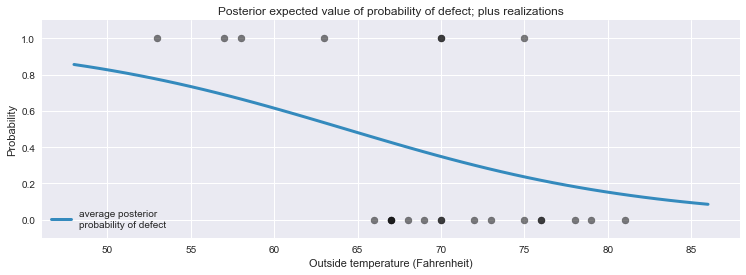

In [137]:
figsize(12.5, 4)
def logistic(x, beta, k):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) - k*beta))

x = np.linspace(t.min() - 5, t.max()+5, 50)
plt.scatter(t, h, s=50, color="k",alpha=0.5)
plt.plot(x, logistic(x, beta_mean, k_mean),lw = 3,label="average posterior \nprobability of defect",color="#348ABD")
plt.ylim((-0.1,1.1))
plt.ylabel("Probability")
plt.xlabel("Temperature")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Posterior expected value of probability of defect; plus realizations")
plt.legend(loc="lower left")
plt.show()

Above we also plotted a possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 900(=max_iter - burn_in) possible dotted lines together.

**To be honest, the average posterior is not as good as I expected, which is rather disappointing.** Yet, an interesting question to ask is for what temperatures are we most uncertain about the defect-probability? Below we plot the expected value line and the associated 80% intervals for each temperature. 

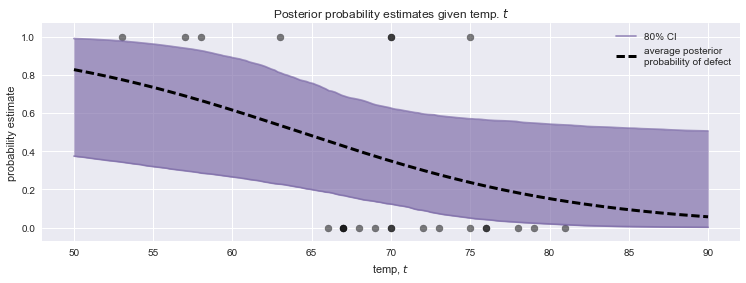

In [139]:
def logistic(x, beta, k):
    return 1.0 / (1.0 + np.exp(beta*x - k*beta))

x = np.linspace(50, 90, 200)
beta_sample = np.array(beta[burnin:])
k_sample = np.array(k[burnin:])
logits = []
for i in range(1000-burnin):
    ans = logistic(x, beta_sample[i], k_sample[i-1])
    logits.append(ans)
pt = np.array(logits)
#print(pt)
qs = sp.stats.mstats.mquantiles (pt,axis = 0,prob =[0.1, 0.9])
#print(qs)
plt.fill_between(x, *qs, alpha=0.65,color="#7A68A6")
plt.plot(x, qs[0], label="80% CI", color="#7A68A6", alpha=0.7)
plt.plot(x, qs[1], color="#7A68A6",alpha =0.7)
plt.plot(x, logistic(x, beta_mean, k_mean),lw = 3,label="average posterior \nprobability of defect",color="k",ls = '--')
plt.scatter(t, h, s=50, color="k",alpha=0.5)
plt.xlabel("temp, $t$")
plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");
plt.legend()
plt.show()

The *80% credible interval*, or 80% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

Again, unlike what expressed in *Probabilistic Programming and Bayesian Methods for Hackers*, the performance of CI is also disappointing, even though, it just tells a simpliest story: the lower the temperature is, the incident is more likely to happen, conversely, the highrt the temperature is, the incident is less likely to happen.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below.

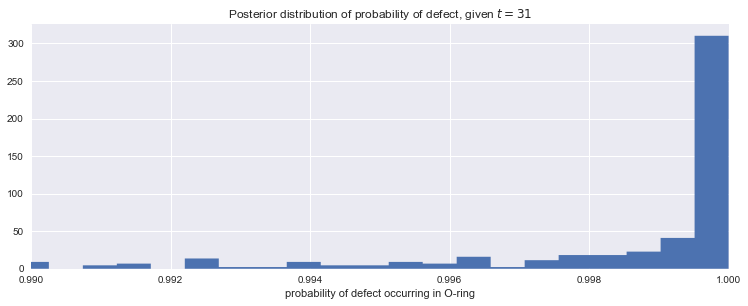

In [140]:
figsize(12.5, 4.5)

prob_31 = logistic(31, beta_sample, k_sample)

plt.xlim(0.99, 1)
plt.hist(prob_31, bins=2000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

Same result as in the book, given temperature = 30, it is clear that the damage incident will happen!!

## What's wrong with our model?

It seems that each step is carefully performed, but we need to be cautious about the problem I just illustrated before - the prior. Since the problem fails to give more observations, we need to redesign our prior, and maybe, gamma distribution is not a good prior or etc.

### Heuristic Prior 2

This time, we use normal distribution as the prior of $\beta$ and $k$ remains unchange. Set $\beta$ ~ N(loc = 1, scale = 0.2), and repeat the same steps above.

In [85]:
def likelihood(h,t,k,beta):
    ans = 1
    for i in range(len(t)):
        ans = ans * np.exp((1-h[i])*beta*(t[i]-k))/(1.0 + np.exp(beta * (t[i]-k)))
    return ans

def k_condition(k,beta,h,t):
    prior  = sp.stats.norm.pdf(k,loc = 65,scale = 2)
    posterior = prior * likelihood(h,t,k,beta)
    return posterior

def beta_condition(beta,k,h,t):
    prior = sp.stats.norm.pdf(beta,loc=1.0,scale=0.2)
    posterior = prior * likelihood(h,t,k,beta)
    return posterior

def joint_posterior(beta,k,h,t):
    joint_prior = sp.stats.norm.pdf(k,loc = 65,scale = 2) * sp.stats.norm.pdf(beta,loc=1.0,scale=0.2)
    joint_posterior = joint_prior * likelihood(h,t,k,beta)
    return joint_posterior

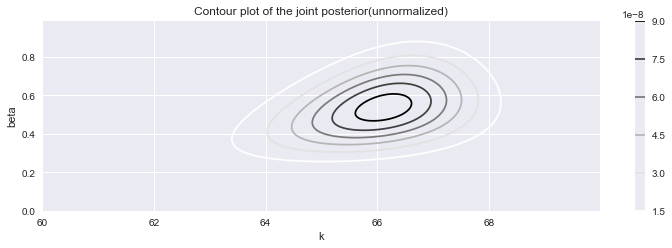

In [86]:
n = len(challenger_data)
k = np.arange(60,70,0.01)
beta = np.arange(0,1,0.01)
k, beta = np.meshgrid(k,beta)
z = joint_posterior(beta,k,h,t)
plt.figure()
CS = plt.contour(k,beta,z)
plt.xlabel('k')
plt.ylabel('beta')
plt.title('Contour plot of the joint posterior(unnormalized)')
plt.colorbar()
plt.show()

### Sampling, Convergence Test and Results

In [87]:
def draw_beta(beta_init,k,h,t):
    # using MH, draw beta from target distribution = beta_condition(beta,k,h,t)
    #init
    beta_list =[]
    b0 = beta_init
    beta_list.append(b0)
    # repeat
    for i in range(1,500):
        u = np.random.uniform(0,1)
        b_star = np.random.normal(loc = beta_list[i-1],scale = 0.05)
        while(b_star<=0):
            b_star = np.random.normal(loc = beta_list[i-1],scale = 0.05)
        #print(b_star,beta_list[i-1])
        #print(beta_condition(b_star,k = k,h = h,t =t))
        acc = min(1, 1.0*beta_condition(b_star,k = k,h = h,t =t)/beta_condition(beta_list[i-1],k=k,h=h,t=t))
        #print(acc)
        if u < acc:
            beta_list.append(b_star)
        else:
            beta_list.append(beta_list[i-1])
    #print('rest:::',beta_list[-1])       
    return beta_list[-1]
    
    
def draw_k(k_init,beta,h,t):
    #MH, draw k from target = k_condition(k,beta,h,t)
    #init
    k_list = []
    k0 = k_init
    k_list.append(k0)
    #repeat
    for i in range(1,500):
        u = np.random.uniform(0,1)
        k_star = np.random.normal(loc = k_list[i-1],scale = 1)
        while (k_star<=0):
            k_star = np.random.normal(loc = k_list[i-1],scale = 1)
        #print(k_star,k_list[i-1])
        #print(k_condition(k_star,beta=beta,h=h,t=t))
        acc = min(1,1.0*k_condition(k_star,beta=beta,h=h,t=t)/k_condition(k_list[i-1],beta=beta,h=h,t=h))
        if u < acc:
            k_list.append(k_star)
        else:
            k_list.append(k_list[i-1])
    #print("res:::",k_list[-1])
    return k_list[-1]
    
def gibbs(h,t,N_iter):
    #init
    k_trace =[]
    beta_trace =[]
    k0 = np.random.uniform(low =30,high= 80)
    k_trace.append(k0)
    b0 = np.random.uniform(0,3)
    beta_trace.append(b0)
    
    for i in range(1,N_iter):
        if (i% 300 == 0):
            print('We have iterated ',i,'times.')
        #sample beta[i] from beta_condition
        b = draw_beta(beta_trace[i-1],k_trace[i-1],h,t)
        beta_trace.append(b)
        #sample k[i] from k_condition
        a = draw_k(k_trace[i-1],beta_trace[i],h,t)
        k_trace.append(a)
    
    return beta_trace,k_trace

In [88]:
import warnings
warnings.filterwarnings("ignore")
beta, k = gibbs(h=h,t=t,N_iter = 1000)

(0, 400)

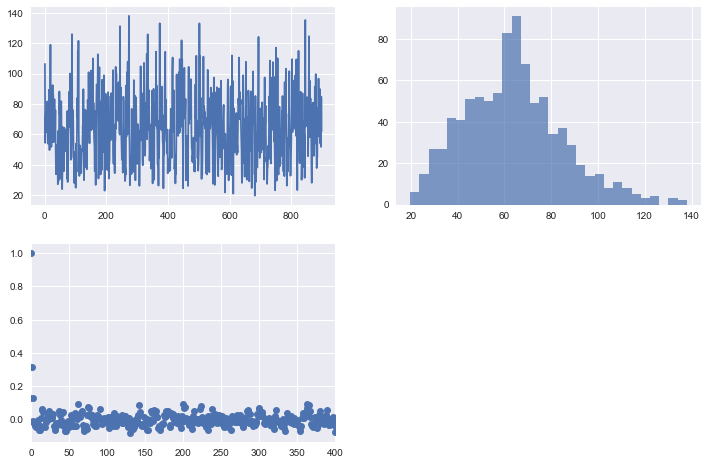

In [91]:
burnin = 100
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(k[burnin:])
plt.subplot(2,2,2) 
fig=plt.hist(k[burnin:],bins=30,alpha = 0.7)
plt.subplot(2,2,3)
plt.acorr(k[burnin:]-np.mean(k[burnin:]),normed=True, usevlines=False, maxlags=400, label=u'Shuffled')

plt.xlim( (0,400))
#print(np.mean(k[burnin:]))
#print(np.var(k[burnin:]))

(0, 400)

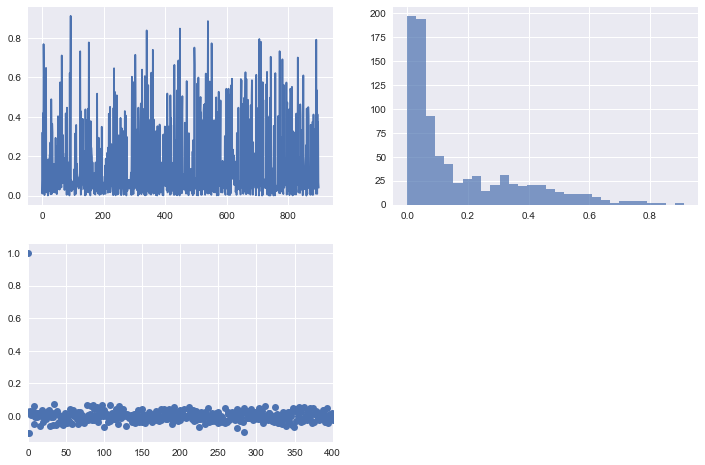

In [92]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(beta[burnin:])
plt.subplot(2,2,2) 
fig=plt.hist(beta[burnin:],bins=30,alpha = 0.7)
plt.subplot(2,2,3)
plt.acorr(beta[burnin:]-np.mean(beta[burnin:]),  normed=True, usevlines=False, maxlags=400, label=u'Shuffled')

plt.xlim( (0,400))
#print(np.mean(beta[burnin:]))
#print(np.var(beta[burnin:]))
#print(np.max(beta[burnin:]))

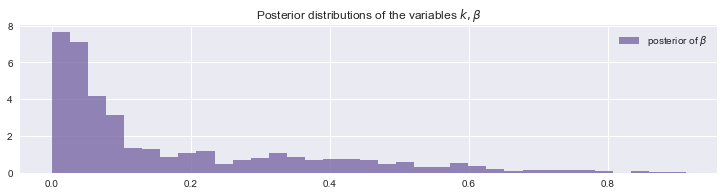

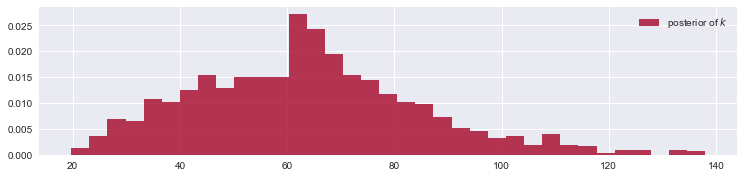

In [93]:
figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $k, \beta$")
plt.hist(beta[burnin:], histtype='stepfilled', bins=35, alpha=0.8,label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()
plt.show()

plt.subplot(212)
plt.hist(k[burnin:], histtype='stepfilled', bins=35, alpha=0.8,label=r"posterior of $k$", color="#A60628", normed=True)
plt.legend()
plt.show()

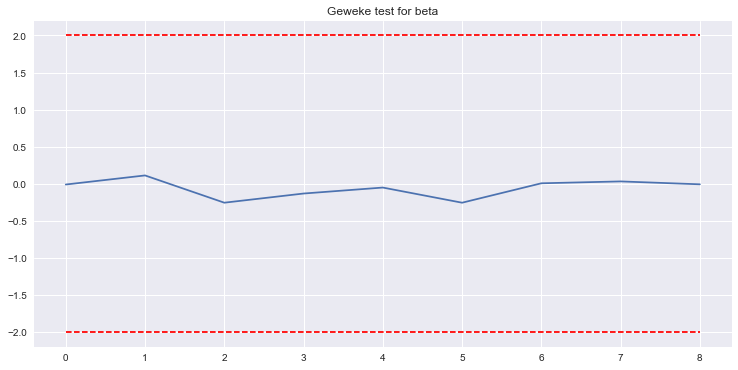

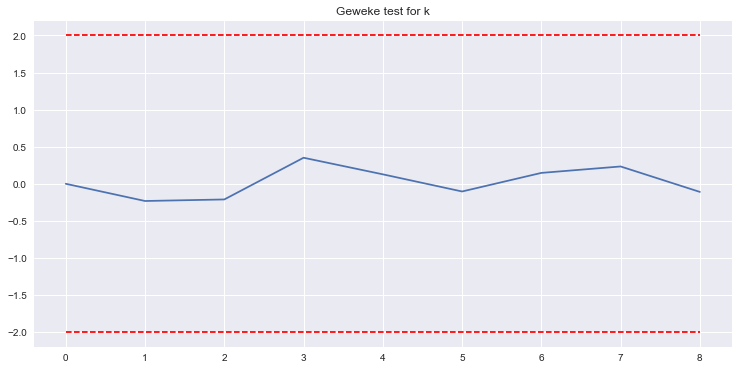

In [96]:
#geweke test
# beta
z_beta = []
z_k = []
halfLen = 500
for i in range(9):
    ba = beta[burnin+50*i:burnin+50*(i+1)]
    bb = beta[halfLen+50*i:halfLen+50*(i+1)]
    z_beta.append((np.mean(ba)-np.mean(bb))/np.sqrt(np.var(ba)+np.var(bb)))
#print(z_beta)
plt.plot(range(9),z_beta)
plt.plot([2]*9,'r--')
plt.plot([-2]*9,'r--')
plt.title('Geweke test for beta')
plt.show()
# k
for i in range(9):
    ka = k[burnin+50*i:burnin+50*(i+1)]
    kb = k[halfLen+50*i:halfLen+50*(i+1)]
    z_k.append((np.mean(ka)-np.mean(kb))/np.sqrt(np.var(ka)+np.var(kb)))
#print(z_k)
plt.plot(range(9),z_k)
plt.plot([2]*9,'r--')
plt.plot([-2]*9,'r--')
plt.title('Geweke test for k')
plt.show()

From the autocorrelation and Geweke test, we can see that the chain has already converges. Then show the results from the samplings.

In [100]:
beta_mean = np.mean(beta[burnin:])
k_mean = np.mean(k[burnin:])
print(r'The estimation of beta = ',beta_mean)
print(r'The estimation of k = ',k_mean)

The estimation of beta =  0.169601465653
The estimation of k =  63.8449962886


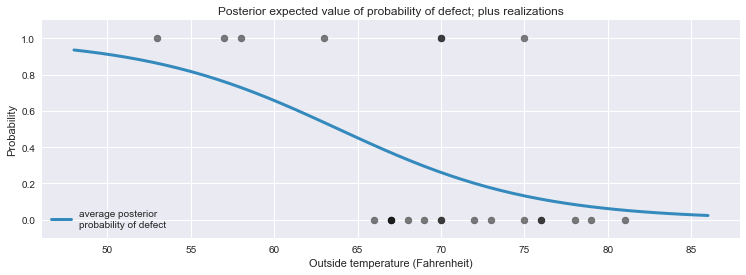

In [102]:
figsize(12.5, 4)
def logistic(x, beta, k):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) - k*beta))

x = np.linspace(t.min() - 5, t.max()+5, 50)
plt.scatter(t, h, s=50, color="k",alpha=0.5)
plt.plot(x, logistic(x, beta_mean, k_mean),lw = 3,label="average posterior \nprobability of defect",color="#348ABD")

plt.ylim((-0.1,1.1))
plt.ylabel("Probability")
plt.xlabel("Temperature")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Posterior expected value of probability of defect; plus realizations")
plt.legend(loc="lower left")
plt.show()

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring, given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings

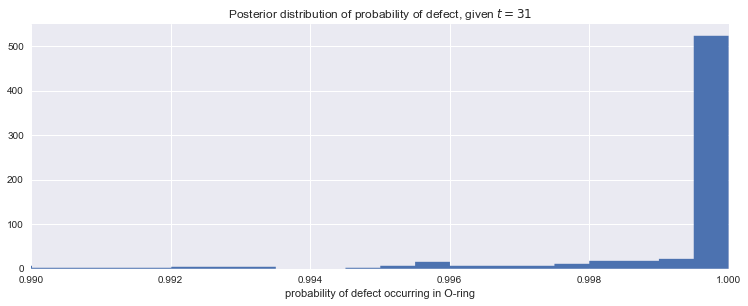

In [107]:
figsize(12.5, 4.5)
beta_sample = np.array(beta[burnin:])
k_sample = np.array(k[burnin:])
prob_31 = logistic(31, beta_sample, k_sample)

plt.xlim(0.99, 1)
plt.hist(prob_31,bins=2000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");


## Rethinking: About the Model

### A classification problem

according to the analysis above, it seems that the sampling method is good(if you don't care about the time). Let's see this problem in another angle: Given the temperuature, perdict happen or unhappen, which is exactly a ***classification problem***! The model we've used is exactly ***logistic regression(LR) classifier ***!

So, I am going to compare the results given by LR and Bayesian method. And then to see whose performance is better.

Fortunately, LR classifier can be easily found in *skelearn*, so just use it! The method I use is Newton-CG, commonly used in machine learning.

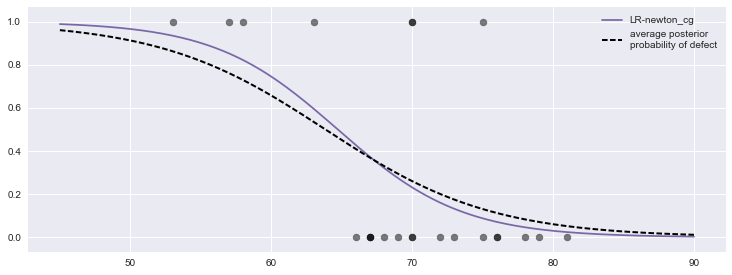

In [110]:
from sklearn import linear_model
def logistic(x, beta, k):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) - k*beta))
one = np.ones(len(t))
feature = np.c_[one,t]
x = np.linspace(45, 90, 200)
xone = np.ones(len(x))
x_test = np.c_[xone,x]
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(feature, h)
h_test = clf.predict_proba(x_test)
plt.plot(x, h_test[:,1], label="LR-newton_cg", color="#7A68A6")
plt.plot(x, logistic(x, beta_mean, k_mean),lw = 2,label="average posterior \nprobability of defect",color="k",ls = '--')
plt.scatter(t, h, s=50, color="k",alpha=0.5)
plt.legend()
plt.show()

### Compare the models

So here comes the problem, whether the logistic regression model or the Bayesian model good? This is the problem of evaluating the model. To solve this problem, we use **cross validation(CV)** to test the prediction function for these two models. The method I use for CV is **leave-one-out** - each time seperate one observation as the test set, and the rest as training dataset. The reason for **leave-one-out** is that there is only 23 observations - not large. So, the following is the implement of cross validation.

#### ***Caution: The program following is very very time-comsuming!***

In [113]:
# CV
hh = h.copy()
mse_lr = []
mse_gib = []
def logistic(x, beta, k):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) - k*beta))

for i in range(23):
    hh = h.copy()
    hh_list = list(hh)
    tt = t.copy()
    tt_list = list(tt)
    h_test = hh_list.pop(i)
    h_train = hh_list
    t_test = tt_list.pop(i)
    t_train = tt_list
    
    one = np.ones(22)
    feature_train = np.c_[one,t_train]
    one = np.ones(1)
    feature_test = np.c_[one,t_test]
    clf = linear_model.LogisticRegression(C=1e5)
    clf.fit(feature_train, h_train)
    h_est = clf.predict_proba(feature_test)
    sse = ((h_est[:,1]-h_test)**2)[0]
    mse_lr.append(sse)
    
    burnin = 20
    beta, k = gibbs(h=h_train,t=t_train,N_iter = 300)
    print('no.',i)
    beta_mean = np.mean(beta[burnin:])
    k_mean = np.mean(k[burnin:])
    h_est_gib = logistic(t_test, beta_mean, k_mean)
    sse_gib = (h_est_gib-h_test)**2
    mse_gib.append(sse_gib)

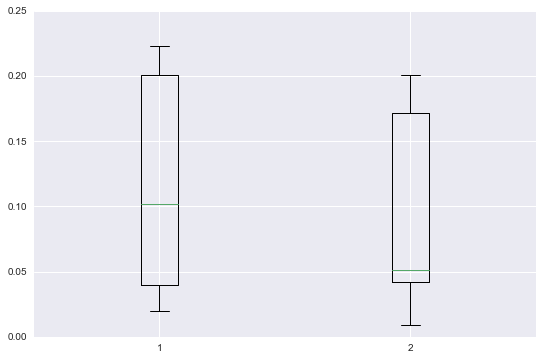

In [118]:
data_to_plot = [mse_lr, mse_gib]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot(data_to_plot)
plt.ylim((0,0.25))
plt.show()

From the boxplot above, 1 is the **mean square error(MSE)** using logistic regression classifier and 2 is using Baysian-sampling method. It is clear that, Baysian-sampling gives smaller MSE, thus is better than logistic regression classifier! But, one thing I must mention is that the Baysian-sampling method is pretty time-consuming comparing to the logistic regression.

## Conclusion

So, let's now recall what I did during the whole process. First of all, I construted a **logistic function** to depict the probabiility of the happening of damage incidents, then I construct a **Bayesian method** and try to estimate the parameters in logistic function. Notice that 23 samples are not so large, so it is important to design the **priors** of the parameters. The fisrt trial of prior to $\beta$ is a **gamma distribution**, because a probability is always larger than zero. For parameter $k$, a normal distribution as prior. Then I used **Gibbs sampler** and designed two **Metropolis algrithms** to sample from the conditional probabilities. After **convergence test**, both a heuristic and a formal one we get the results of estimation. Unfortunately, the result was not satisifatory as I expected. So, for the second trial, I redesign the prior, and this time, I used **normal prior** for $\beta$, and repeat the previous steps. This time, the model works better than the previous one. So, when data is small, the prior is a essential part when sampling, but when talking to how to design a "GOOD" prior, my experience told me, just trials.

After construting the **Bayesian-sampling model**, I suddenly found that this problem in another perespective, is a classification problem, so **logistic regression classifier**, a classic method for classification came into my mind. In order to estimate the model, I compared model of logistic regression and Bayesian-sampling by doing **leave-one-out cross validation**. The results of mean square error showed that Bayesian-sampling method does better than logistic regression. Still, when it comes to the **time complexity** of the model, a Bayesian-sampling method is MUCH inferior to logistic regression classification.